In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Bidirectional, TimeDistributed, Flatten, Activation, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint

from tqdm.notebook import tqdm
from statistics import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

# Load & Prepare Data

In [2]:
# Load Data
df = yf.download(tickers='RCDO.L', start='2012-01-01', end='2023-01-01')
df = df[['Close']]
df

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2012-01-03,381.5
2012-01-04,384.0
2012-01-05,383.5
2012-01-06,383.5
2012-01-09,380.0
...,...
2022-12-22,475.0
2022-12-23,475.0
2022-12-28,477.5


In [3]:
# training between 2012 and 2022
train_data_df = df[df.index < '2022-01-01'].copy()

# validation on 2022
val_data_df = df[df.index >= '2022-01-01'].copy()

display(train_data_df, val_data_df)

,Close
Date,
2012-01-03,381.5
2012-01-04,384.0
2012-01-05,383.5
2012-01-06,383.5
2012-01-09,380.0
...,...
2021-12-23,465.0
2021-12-24,464.0
2021-12-29,462.0


,Close
Date,
2022-01-04,457.0
2022-01-05,463.0
2022-01-06,466.0
2022-01-07,467.0
2022-01-10,463.0
...,...
2022-12-22,475.0
2022-12-23,475.0
2022-12-28,477.5


# Models

In [4]:
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.yticks([i/1000 for i in range(0, 25, 5)])
    plt.legend()
    plt.show()

In [5]:
def visualise_predicitons(test_data_df, pred):
    """Plot predictions against actual test data"""
    
    pred_ = pd.DataFrame(test_data_df['Close'])
    pred_['predicted close'] = pred
    
    plt.figure(figsize=(28,12))
    sns.lineplot(test_data_df['Close'])
    sns.lineplot(pred_['predicted close'])
    plt.show()

In [6]:
def run_model(train_data_df, val_data_df, chosen_model):

    #### Prepare Train Data ####
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data_df)

    prediction_days = 7

    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-prediction_days:i])
        y_train.append(scaled_train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b
    #### Prepare Val Data ####
    look_back = train_data_df.tail(prediction_days)
    val_data = look_back.append(val_data_df)

    scaled_val_data = scaler.transform(val_data)

    x_val = []
    y_val = []
    
    for i in range(prediction_days, len(scaled_val_data)):
        x_val.append(scaled_val_data[i-prediction_days:i])
        y_val.append(scaled_val_data[i, 0])

    x_val, y_val = np.array(x_val), np.array(y_val)
    
    ##### Run model #####
    model = chosen_model
    model.summary()
    model.compile(optimizer='adam', 
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=100)
    
    ##### Plot loss #####
    plot_loss(history)

    ##### Generate predictions (probabilities - the output of the last layer) on new data using `predict` #####
    print("Generate predictions for 7 samples")
    predictions = model.predict(x_val[:7])
    print("predictions shape:", predictions.shape)
    print(predictions)
    
    ##### Metrics #####
    pred = model.predict(x_val)
    print(pred.shape)

    # Inverse MinMax Transformation
    # Requires same amount of fields
    # https://stackoverflow.com/questions/42997228/lstm-keras-error-valueerror-non-broadcastable-output-operand-with-shape-67704
    # create empty table with 12 fields
    pred_like = np.zeros(shape=(len(pred), 1) )
    # put the predicted values in the right field
    pred_like[:,0] = pred[:,0]
    # inverse transform and then select the right field
    pred = scaler.inverse_transform(pred_like)[:,0]

    print('mae:', mean_absolute_error(val_data_df['Close'], pred))
    print('mape:', mean_absolute_percentage_error(val_data_df['Close'], pred))
    print('mse:', mean_squared_error(val_data_df['Close'], pred))
    print('rmse:', math.sqrt(mean_squared_error(val_data_df['Close'], pred)))

    ##### Visualise #####
    print(y_val.shape, pred.shape)
    visualise_predicitons(val_data_df, pred)

    display(pd.DataFrame(data={'Train Predictions':pred.flatten(), 'Actuals':val_data_df['Close']}))

In [7]:
def run_model_average(train_data_df, val_data_df, chosen_model):

    #### Prepare Train Data ####
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data_df)

    prediction_days = 7

    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-prediction_days:i])
        y_train.append(scaled_train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b
    #### Prepare Val Data ####
    look_back = train_data_df.tail(prediction_days)
    val_data = look_back.append(val_data_df)

    scaled_val_data = scaler.transform(val_data)

    x_val = []
    y_val = []
    
    for i in range(prediction_days, len(scaled_val_data)):
        x_val.append(scaled_val_data[i-prediction_days:i])
        y_val.append(scaled_val_data[i, 0])

    x_val, y_val = np.array(x_val), np.array(y_val)
    
    mape_values = []
    mae_values = []
    mse_values = []
    rmse_values = []
    
    for i in (range(35)):
        
        ##### Run model #####
        model = chosen_model
        model.summary()
        model.compile(optimizer='adam', 
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])

        history = model.fit(x_train, y_train, validation_split=0.1, epochs=100)

        ##### Generate predictions (probabilities - the output of the last layer) on new data using `predict` #####
        print("Generate predictions for 7 samples")
        predictions = model.predict(x_val[:7])
        print("predictions shape:", predictions.shape)
        print(predictions)

        ##### Metrics #####
        pred = model.predict(x_val)
        print(pred.shape)

        # Inverse MinMax Transformation
        # Requires same amount of fields
        # https://stackoverflow.com/questions/42997228/lstm-keras-error-valueerror-non-broadcastable-output-operand-with-shape-67704
        # create empty table with 12 fields
        pred_like = np.zeros(shape=(len(pred), 1) )
        # put the predicted values in the right field
        pred_like[:,0] = pred[:,0]
        # inverse transform and then select the right field
        pred = scaler.inverse_transform(pred_like)[:,0]
    
        mae_values.append(mean_absolute_error(val_data_df['Close'], pred))
        mape_values.append(mean_absolute_percentage_error(val_data_df['Close'], pred))
        mse_values.append(mean_squared_error(val_data_df['Close'], pred))
        rmse_values.append(math.sqrt(mean_squared_error(val_data_df['Close'], pred)))
        
        print(mean(mae_values), mean(mape_values), mean(mse_values), mean(rmse_values))
        
    return mae_values, mape_values, mse_values, rmse_values

In [8]:
compare_df = pd.DataFrame(columns=['Name', 'MAE', 'MAPE', 'MSE', 'RMSE'])

## Stacked LSTM

In [9]:
def stacked_lstm():
    model = Sequential()    
    model.add(LSTM(units=140, input_shape=(7, 1), return_sequences=True))
    model.add(LSTM(units=20))
    model.add(Dense(1))
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 140)            79520     
                                                                 
 lstm_1 (LSTM)               (None, 20)                12880     
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 16ms/step - loss: 0.0279 - mean_absolute_error: 0.0980 - val_loss: 4.6183e-04 - val_mean_absolute_error: 0.0163
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0230 - val_loss: 4.7685e-04 - val_mean_abso

Epoch 92/100
71/71 [==============================] - 0s 7ms/step - loss: 3.7349e-04 - mean_absolute_error: 0.0134 - val_loss: 1.2958e-04 - val_mean_absolute_error: 0.0081
Epoch 93/100
71/71 [==============================] - 0s 7ms/step - loss: 3.5430e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3624e-04 - val_mean_absolute_error: 0.0081
Epoch 94/100
71/71 [==============================] - 0s 7ms/step - loss: 3.8985e-04 - mean_absolute_error: 0.0137 - val_loss: 1.3415e-04 - val_mean_absolute_error: 0.0084
Epoch 95/100
71/71 [==============================] - 0s 7ms/step - loss: 3.7338e-04 - mean_absolute_error: 0.0134 - val_loss: 1.3387e-04 - val_mean_absolute_error: 0.0080
Epoch 96/100
71/71 [==============================] - 0s 7ms/step - loss: 3.9953e-04 - mean_absolute_error: 0.0140 - val_loss: 1.2848e-04 - val_mean_absolute_error: 0.0079
Epoch 97/100
71/71 [==============================] - 1s 7ms/step - loss: 3.6354e-04 - mean_absolute_error: 0.0130 - val_loss: 1.5547e-04 - 

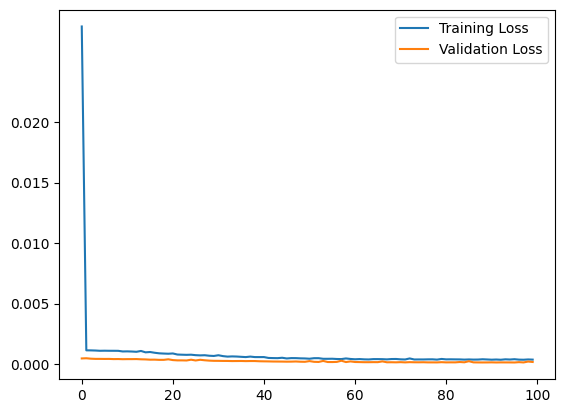

Generate predictions for 7 samples
1/1 [==============================] - 1s 583ms/step
predictions shape: (7, 1)
[[0.19539005]
 [0.20339626]
 [0.21178141]
 [0.21580663]
 [0.21707134]
 [0.21285045]
 [0.20890191]]
8/8 [==============================] - 0s 2ms/step
(250, 1)
mae: 7.625448639199138
mape: 0.018513194186770936
mse: 91.45895601141042
rmse: 9.56341759055885
(250,) (250,)


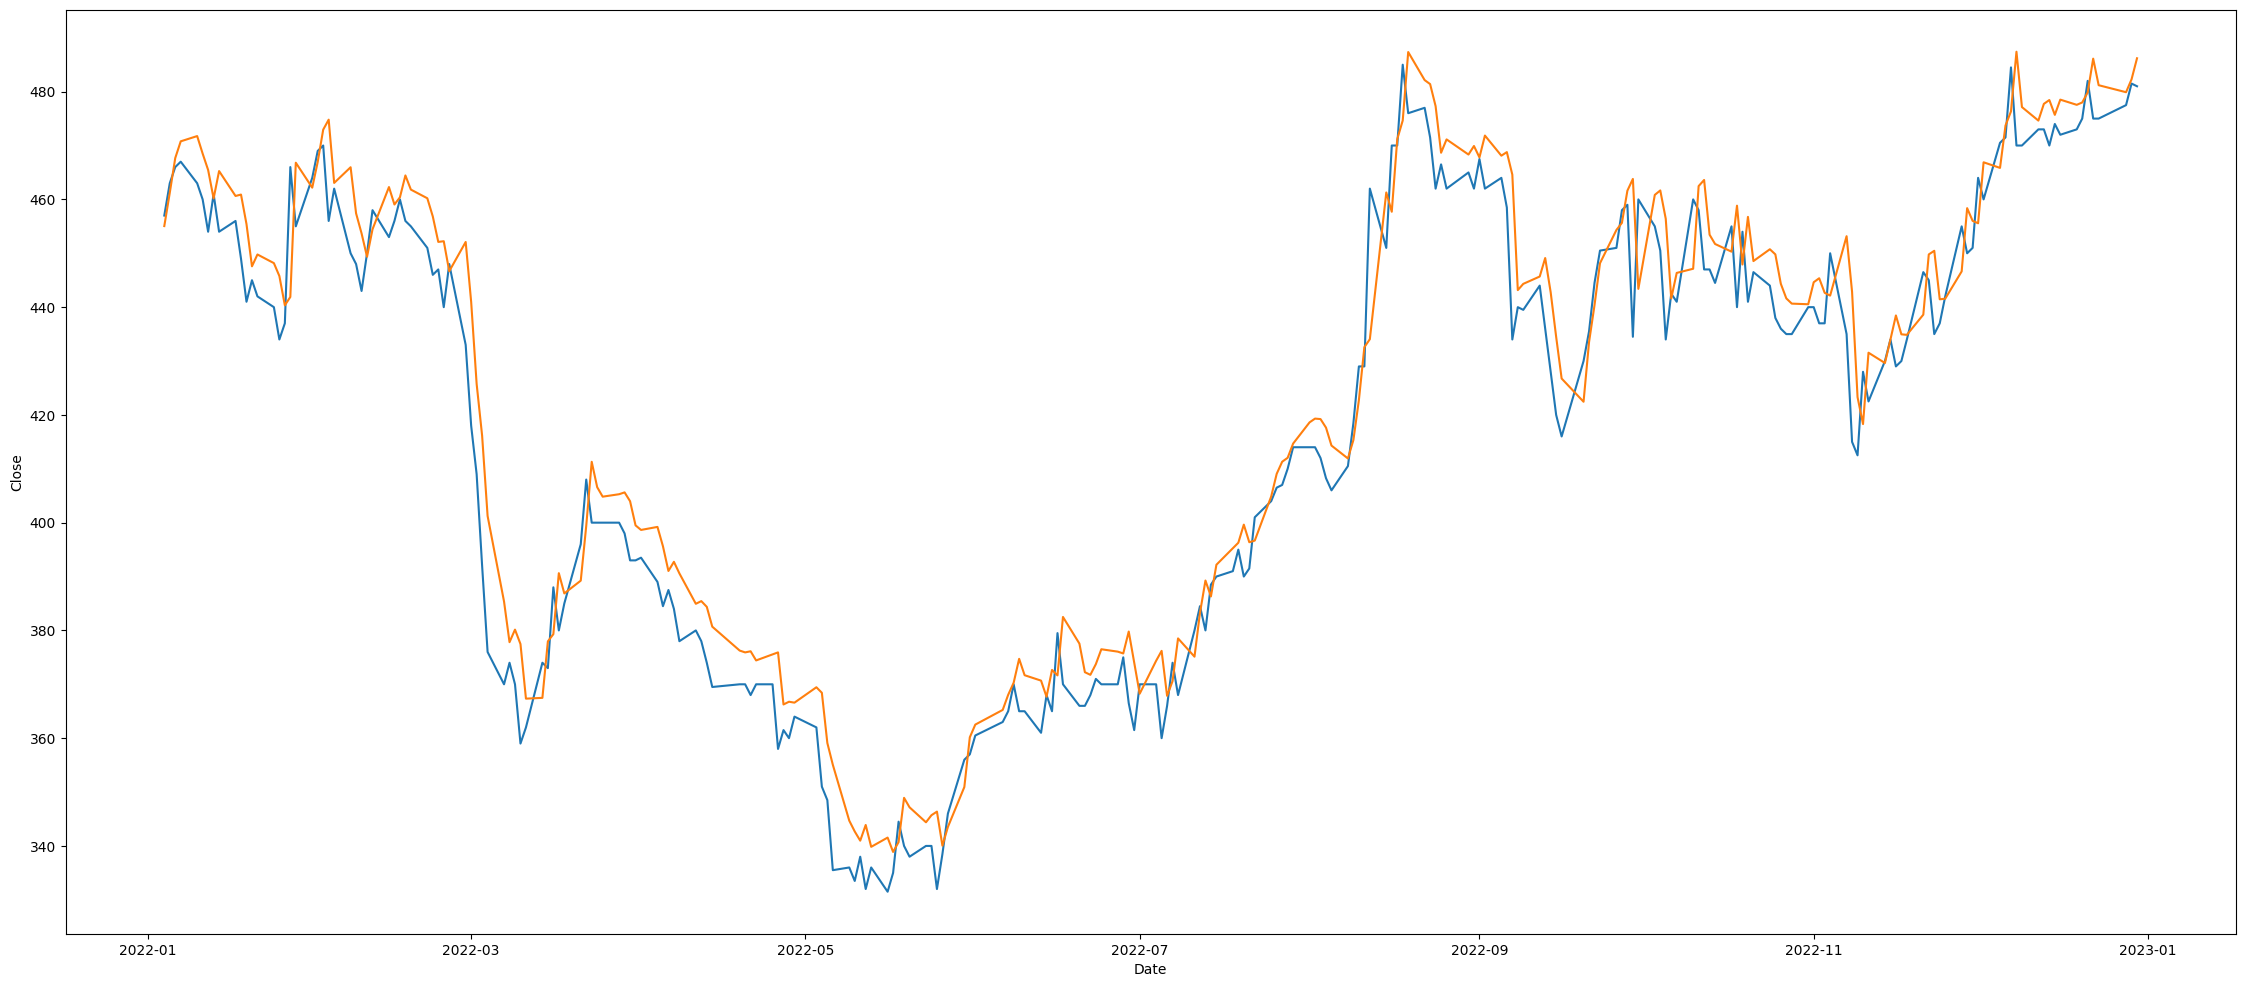

,Train Predictions,Actuals
Date,,
2022-01-04,455.048030,457.0
2022-01-05,461.216819,463.0
2022-01-06,467.677578,466.0
2022-01-07,470.779011,467.0
2022-01-10,471.753467,463.0
...,...,...
2022-12-22,486.126653,475.0
2022-12-23,481.196552,475.0
2022-12-28,479.896404,477.5


In [10]:
run_model(train_data_df, val_data_df, chosen_model = stacked_lstm())

In [11]:
mae_values_2, mape_values_2, mse_values_2, rmse_values_2 = run_model_average(train_data_df, val_data_df, chosen_model = stacked_lstm())
 
model_dict = {
'Name':'LSTM 2',
'MAE': round(mean(mae_values_2), 4),
"MAPE": round(mean(mape_values_2), 4),
"MSE": round(mean(mse_values_2), 4),
"RMSE": round(mean(rmse_values_2), 4)
}

compare_df = compare_df.append(model_dict, ignore_index=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 16ms/step - loss: 0.0193 - mean_absolute_error: 0.0820 - val_loss: 5.0296e-04 - val_mean_absolute_error: 0.0171
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0225 - val_loss: 4.2051e-04 - val_mean_ab

Epoch 92/100
71/71 [==============================] - 1s 9ms/step - loss: 3.8130e-04 - mean_absolute_error: 0.0135 - val_loss: 1.3688e-04 - val_mean_absolute_error: 0.0084
Epoch 93/100
71/71 [==============================] - 1s 8ms/step - loss: 4.0180e-04 - mean_absolute_error: 0.0141 - val_loss: 1.3216e-04 - val_mean_absolute_error: 0.0080
Epoch 94/100
71/71 [==============================] - 1s 7ms/step - loss: 4.0490e-04 - mean_absolute_error: 0.0142 - val_loss: 1.5956e-04 - val_mean_absolute_error: 0.0096
Epoch 95/100
71/71 [==============================] - 1s 8ms/step - loss: 3.7444e-04 - mean_absolute_error: 0.0133 - val_loss: 1.3191e-04 - val_mean_absolute_error: 0.0080
Epoch 96/100
71/71 [==============================] - 1s 8ms/step - loss: 3.8333e-04 - mean_absolute_error: 0.0135 - val_loss: 1.3886e-04 - val_mean_absolute_error: 0.0087
Epoch 97/100
71/71 [==============================] - 1s 8ms/step - loss: 3.8121e-04 - mean_absolute_error: 0.0136 - val_loss: 1.4508e-04 - 

Epoch 33/100
71/71 [==============================] - 1s 7ms/step - loss: 3.5801e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3268e-04 - val_mean_absolute_error: 0.0080
Epoch 34/100
71/71 [==============================] - 1s 7ms/step - loss: 3.5619e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3003e-04 - val_mean_absolute_error: 0.0082
Epoch 35/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5749e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3284e-04 - val_mean_absolute_error: 0.0080
Epoch 36/100
71/71 [==============================] - 1s 7ms/step - loss: 4.0606e-04 - mean_absolute_error: 0.0143 - val_loss: 1.4742e-04 - val_mean_absolute_error: 0.0087
Epoch 37/100
71/71 [==============================] - 1s 8ms/step - loss: 3.6607e-04 - mean_absolute_error: 0.0133 - val_loss: 1.2802e-04 - val_mean_absolute_error: 0.0081
Epoch 38/100
71/71 [==============================] - 1s 8ms/step - loss: 3.6460e-04 - mean_absolute_error: 0.0134 - val_loss: 1.3289e-04 - 

Epoch 21/100
71/71 [==============================] - 1s 7ms/step - loss: 3.6316e-04 - mean_absolute_error: 0.0131 - val_loss: 1.3326e-04 - val_mean_absolute_error: 0.0081
Epoch 22/100
71/71 [==============================] - 1s 7ms/step - loss: 3.5854e-04 - mean_absolute_error: 0.0131 - val_loss: 1.3462e-04 - val_mean_absolute_error: 0.0082
Epoch 23/100
71/71 [==============================] - 1s 7ms/step - loss: 3.7056e-04 - mean_absolute_error: 0.0133 - val_loss: 1.3072e-04 - val_mean_absolute_error: 0.0082
Epoch 24/100
71/71 [==============================] - 1s 8ms/step - loss: 3.6018e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3152e-04 - val_mean_absolute_error: 0.0080
Epoch 25/100
71/71 [==============================] - 1s 7ms/step - loss: 3.4631e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3941e-04 - val_mean_absolute_error: 0.0082
Epoch 26/100
71/71 [==============================] - 1s 7ms/step - loss: 3.6127e-04 - mean_absolute_error: 0.0131 - val_loss: 1.5484e-04 - 

Epoch 9/100
71/71 [==============================] - 1s 7ms/step - loss: 3.4704e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3527e-04 - val_mean_absolute_error: 0.0081
Epoch 10/100
71/71 [==============================] - 1s 7ms/step - loss: 3.5927e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3190e-04 - val_mean_absolute_error: 0.0083
Epoch 11/100
71/71 [==============================] - 1s 7ms/step - loss: 3.4248e-04 - mean_absolute_error: 0.0126 - val_loss: 1.2861e-04 - val_mean_absolute_error: 0.0080
Epoch 12/100
71/71 [==============================] - 1s 7ms/step - loss: 3.5304e-04 - mean_absolute_error: 0.0129 - val_loss: 1.4303e-04 - val_mean_absolute_error: 0.0086
Epoch 13/100
71/71 [==============================] - 0s 7ms/step - loss: 3.5177e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3939e-04 - val_mean_absolute_error: 0.0084
Epoch 14/100
71/71 [==============================] - 1s 7ms/step - loss: 3.5086e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3729e-04 - v

 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 16ms/step - loss: 3.4589e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3841e-04 - val_mean_absolute_error: 0.0084
Epoch 2/100
71/71 [==============================] - 0s 7ms/step - loss: 3.4309e-04 - mean_absolute_error: 0.0129 - val_loss: 1.6154e-04 - val_mean_absolute_error: 0.0093
Epoch 3/100
71/71 [==============================] - 1s 7ms/step - loss: 3.5664e-04 - mean_absolute_error: 0.0133 - val_loss:

Epoch 45/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3468e-04 - mean_absolute_error: 0.0128 - val_loss: 1.4718e-04 - val_mean_absolute_error: 0.0088
Epoch 46/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3966e-04 - mean_absolute_error: 0.0128 - val_loss: 1.4645e-04 - val_mean_absolute_error: 0.0085
Epoch 47/100
71/71 [==============================] - 1s 8ms/step - loss: 3.4486e-04 - mean_absolute_error: 0.0131 - val_loss: 1.4205e-04 - val_mean_absolute_error: 0.0082
Epoch 48/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2993e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3970e-04 - val_mean_absolute_error: 0.0082
Epoch 49/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3458e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3950e-04 - val_mean_absolute_error: 0.0082
Epoch 50/100
71/71 [==============================] - 1s 9ms/step - loss: 3.4343e-04 - mean_absolute_error: 0.0129 - val_loss: 1.4283e-04 - 

Epoch 33/100
71/71 [==============================] - 0s 7ms/step - loss: 3.3717e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3415e-04 - val_mean_absolute_error: 0.0082
Epoch 34/100
71/71 [==============================] - 1s 7ms/step - loss: 3.3654e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3293e-04 - val_mean_absolute_error: 0.0080
Epoch 35/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2783e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4536e-04 - val_mean_absolute_error: 0.0085
Epoch 36/100
71/71 [==============================] - 1s 7ms/step - loss: 3.4041e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3145e-04 - val_mean_absolute_error: 0.0080
Epoch 37/100
71/71 [==============================] - 1s 7ms/step - loss: 3.4622e-04 - mean_absolute_error: 0.0130 - val_loss: 1.5805e-04 - val_mean_absolute_error: 0.0090
Epoch 38/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3307e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4843e-04 - 

Epoch 21/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2840e-04 - mean_absolute_error: 0.0127 - val_loss: 1.7618e-04 - val_mean_absolute_error: 0.0099
Epoch 22/100
71/71 [==============================] - 1s 7ms/step - loss: 3.4551e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3150e-04 - val_mean_absolute_error: 0.0081
Epoch 23/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2149e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4011e-04 - val_mean_absolute_error: 0.0083
Epoch 24/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2771e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3739e-04 - val_mean_absolute_error: 0.0082
Epoch 25/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2102e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4255e-04 - val_mean_absolute_error: 0.0085
Epoch 26/100
71/71 [==============================] - 1s 7ms/step - loss: 3.4928e-04 - mean_absolute_error: 0.0131 - val_loss: 1.3985e-04 - 

Epoch 9/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2341e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3141e-04 - val_mean_absolute_error: 0.0080
Epoch 10/100
71/71 [==============================] - 1s 7ms/step - loss: 3.3216e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4374e-04 - val_mean_absolute_error: 0.0088
Epoch 11/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2943e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3697e-04 - val_mean_absolute_error: 0.0083
Epoch 12/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2941e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4741e-04 - val_mean_absolute_error: 0.0087
Epoch 13/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2442e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4501e-04 - val_mean_absolute_error: 0.0084
Epoch 14/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2656e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3594e-04 - v

 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 16ms/step - loss: 3.3089e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3779e-04 - val_mean_absolute_error: 0.0085
Epoch 2/100
71/71 [==============================] - 0s 7ms/step - loss: 3.1742e-04 - mean_absolute_error: 0.0125 - val_loss: 1.6221e-04 - val_mean_absolute_error: 0.0092
Epoch 3/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1727e-04 - mean_absolute_error: 0.0124 - val_loss:

Epoch 45/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2882e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3233e-04 - val_mean_absolute_error: 0.0081
Epoch 46/100
71/71 [==============================] - 0s 7ms/step - loss: 3.1409e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3491e-04 - val_mean_absolute_error: 0.0083
Epoch 47/100
71/71 [==============================] - 1s 7ms/step - loss: 3.3830e-04 - mean_absolute_error: 0.0128 - val_loss: 1.5632e-04 - val_mean_absolute_error: 0.0093
Epoch 48/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2670e-04 - mean_absolute_error: 0.0126 - val_loss: 1.5696e-04 - val_mean_absolute_error: 0.0090
Epoch 49/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2821e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3695e-04 - val_mean_absolute_error: 0.0082
Epoch 50/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2986e-04 - mean_absolute_error: 0.0128 - val_loss: 1.4730e-04 - 

Epoch 33/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2425e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3804e-04 - val_mean_absolute_error: 0.0085
Epoch 34/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2605e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3875e-04 - val_mean_absolute_error: 0.0086
Epoch 35/100
71/71 [==============================] - 1s 9ms/step - loss: 3.2003e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4165e-04 - val_mean_absolute_error: 0.0084
Epoch 36/100
71/71 [==============================] - 1s 10ms/step - loss: 3.2365e-04 - mean_absolute_error: 0.0125 - val_loss: 1.5185e-04 - val_mean_absolute_error: 0.0087
Epoch 37/100
71/71 [==============================] - 1s 9ms/step - loss: 3.1793e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3057e-04 - val_mean_absolute_error: 0.0080
Epoch 38/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1920e-04 - mean_absolute_error: 0.0124 - val_loss: 1.5390e-04 -

Epoch 21/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2122e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4833e-04 - val_mean_absolute_error: 0.0086
Epoch 22/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2047e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3872e-04 - val_mean_absolute_error: 0.0083
Epoch 23/100
71/71 [==============================] - 0s 7ms/step - loss: 3.1344e-04 - mean_absolute_error: 0.0122 - val_loss: 1.5551e-04 - val_mean_absolute_error: 0.0090
Epoch 24/100
71/71 [==============================] - 1s 9ms/step - loss: 3.1391e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3217e-04 - val_mean_absolute_error: 0.0082
Epoch 25/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1266e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4072e-04 - val_mean_absolute_error: 0.0083
Epoch 26/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1595e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3939e-04 - 

Epoch 9/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1630e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3500e-04 - val_mean_absolute_error: 0.0082
Epoch 10/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0987e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3191e-04 - val_mean_absolute_error: 0.0082
Epoch 11/100
71/71 [==============================] - 1s 7ms/step - loss: 3.2279e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4379e-04 - val_mean_absolute_error: 0.0087
Epoch 12/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1010e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3602e-04 - val_mean_absolute_error: 0.0082
Epoch 13/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1572e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4171e-04 - val_mean_absolute_error: 0.0085
Epoch 14/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1189e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3723e-04 - v

 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 16ms/step - loss: 3.2069e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3701e-04 - val_mean_absolute_error: 0.0083
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0354e-04 - mean_absolute_error: 0.0121 - val_loss: 1.3438e-04 - val_mean_absolute_error: 0.0081
Epoch 3/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1722e-04 - mean_absolute_error: 0.0124 - val_loss:

Epoch 45/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1210e-04 - mean_absolute_error: 0.0124 - val_loss: 1.5532e-04 - val_mean_absolute_error: 0.0093
Epoch 46/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1208e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4738e-04 - val_mean_absolute_error: 0.0086
Epoch 47/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0883e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4061e-04 - val_mean_absolute_error: 0.0083
Epoch 48/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1909e-04 - mean_absolute_error: 0.0125 - val_loss: 1.5252e-04 - val_mean_absolute_error: 0.0088
Epoch 49/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1794e-04 - mean_absolute_error: 0.0124 - val_loss: 1.8407e-04 - val_mean_absolute_error: 0.0105
Epoch 50/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1130e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3871e-04 - 

Epoch 33/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0384e-04 - mean_absolute_error: 0.0121 - val_loss: 1.3887e-04 - val_mean_absolute_error: 0.0083
Epoch 34/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0592e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4275e-04 - val_mean_absolute_error: 0.0084
Epoch 35/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0375e-04 - mean_absolute_error: 0.0121 - val_loss: 1.3804e-04 - val_mean_absolute_error: 0.0083
Epoch 36/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0989e-04 - mean_absolute_error: 0.0122 - val_loss: 1.6452e-04 - val_mean_absolute_error: 0.0096
Epoch 37/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1098e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4373e-04 - val_mean_absolute_error: 0.0084
Epoch 38/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0713e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4304e-04 - 

Epoch 21/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0871e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4163e-04 - val_mean_absolute_error: 0.0083
Epoch 22/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0749e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4097e-04 - val_mean_absolute_error: 0.0083
Epoch 23/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0177e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4185e-04 - val_mean_absolute_error: 0.0085
Epoch 24/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0460e-04 - mean_absolute_error: 0.0122 - val_loss: 1.5846e-04 - val_mean_absolute_error: 0.0089
Epoch 25/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1053e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4553e-04 - val_mean_absolute_error: 0.0086
Epoch 26/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0436e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4205e-04 - 

Epoch 9/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1144e-04 - mean_absolute_error: 0.0124 - val_loss: 1.5069e-04 - val_mean_absolute_error: 0.0086
Epoch 10/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9965e-04 - mean_absolute_error: 0.0120 - val_loss: 1.4085e-04 - val_mean_absolute_error: 0.0084
Epoch 11/100
71/71 [==============================] - 1s 8ms/step - loss: 2.9884e-04 - mean_absolute_error: 0.0120 - val_loss: 1.3910e-04 - val_mean_absolute_error: 0.0083
Epoch 12/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9988e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5059e-04 - val_mean_absolute_error: 0.0090
Epoch 13/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0721e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4571e-04 - val_mean_absolute_error: 0.0085
Epoch 14/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0589e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4192e-04 - v

 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 16ms/step - loss: 3.0177e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4279e-04 - val_mean_absolute_error: 0.0084
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0189e-04 - mean_absolute_error: 0.0121 - val_loss: 1.4534e-04 - val_mean_absolute_error: 0.0087
Epoch 3/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0733e-04 - mean_absolute_error: 0.0124 - val_loss:

Epoch 45/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0936e-04 - mean_absolute_error: 0.0124 - val_loss: 1.5920e-04 - val_mean_absolute_error: 0.0088
Epoch 46/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9544e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5562e-04 - val_mean_absolute_error: 0.0088
Epoch 47/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0496e-04 - mean_absolute_error: 0.0123 - val_loss: 1.6628e-04 - val_mean_absolute_error: 0.0096
Epoch 48/100
71/71 [==============================] - 1s 7ms/step - loss: 3.1098e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4163e-04 - val_mean_absolute_error: 0.0084
Epoch 49/100
71/71 [==============================] - 1s 7ms/step - loss: 3.0006e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4654e-04 - val_mean_absolute_error: 0.0085
Epoch 50/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9686e-04 - mean_absolute_error: 0.0120 - val_loss: 1.4941e-04 - 

Epoch 33/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9358e-04 - mean_absolute_error: 0.0120 - val_loss: 1.6538e-04 - val_mean_absolute_error: 0.0090
Epoch 34/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0963e-04 - mean_absolute_error: 0.0124 - val_loss: 1.5982e-04 - val_mean_absolute_error: 0.0089
Epoch 35/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1345e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4947e-04 - val_mean_absolute_error: 0.0085
Epoch 36/100
71/71 [==============================] - 1s 9ms/step - loss: 3.0447e-04 - mean_absolute_error: 0.0123 - val_loss: 1.6332e-04 - val_mean_absolute_error: 0.0088
Epoch 37/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0345e-04 - mean_absolute_error: 0.0122 - val_loss: 2.5073e-04 - val_mean_absolute_error: 0.0122
Epoch 38/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0265e-04 - mean_absolute_error: 0.0123 - val_loss: 1.7378e-04 - 

Epoch 21/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8783e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6330e-04 - val_mean_absolute_error: 0.0090
Epoch 22/100
71/71 [==============================] - 1s 8ms/step - loss: 2.9584e-04 - mean_absolute_error: 0.0122 - val_loss: 1.7538e-04 - val_mean_absolute_error: 0.0092
Epoch 23/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9056e-04 - mean_absolute_error: 0.0120 - val_loss: 1.6564e-04 - val_mean_absolute_error: 0.0091
Epoch 24/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9367e-04 - mean_absolute_error: 0.0121 - val_loss: 1.9719e-04 - val_mean_absolute_error: 0.0105
Epoch 25/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9108e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7161e-04 - val_mean_absolute_error: 0.0092
Epoch 26/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9285e-04 - mean_absolute_error: 0.0120 - val_loss: 1.7525e-04 - 

Epoch 9/100
71/71 [==============================] - 1s 7ms/step - loss: 2.8790e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6129e-04 - val_mean_absolute_error: 0.0091
Epoch 10/100
71/71 [==============================] - 1s 8ms/step - loss: 2.9272e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6509e-04 - val_mean_absolute_error: 0.0090
Epoch 11/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9634e-04 - mean_absolute_error: 0.0122 - val_loss: 1.7470e-04 - val_mean_absolute_error: 0.0092
Epoch 12/100
71/71 [==============================] - 1s 7ms/step - loss: 2.8714e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7133e-04 - val_mean_absolute_error: 0.0091
Epoch 13/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8196e-04 - mean_absolute_error: 0.0118 - val_loss: 1.8139e-04 - val_mean_absolute_error: 0.0097
Epoch 14/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8972e-04 - mean_absolute_error: 0.0120 - val_loss: 1.7926e-04 - v

 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 17ms/step - loss: 2.8680e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6589e-04 - val_mean_absolute_error: 0.0091
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7602e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7138e-04 - val_mean_absolute_error: 0.0091
Epoch 3/100
71/71 [==============================] - 1s 8ms/step - loss: 2.9740e-04 - mean_absolute_error: 0.0122 - val_loss:

Epoch 45/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9201e-04 - mean_absolute_error: 0.0121 - val_loss: 1.7514e-04 - val_mean_absolute_error: 0.0094
Epoch 46/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8637e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7283e-04 - val_mean_absolute_error: 0.0092
Epoch 47/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8509e-04 - mean_absolute_error: 0.0119 - val_loss: 1.9241e-04 - val_mean_absolute_error: 0.0102
Epoch 48/100
71/71 [==============================] - 1s 7ms/step - loss: 2.8417e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7948e-04 - val_mean_absolute_error: 0.0096
Epoch 49/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8333e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6687e-04 - val_mean_absolute_error: 0.0093
Epoch 50/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7974e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6730e-04 - 

Epoch 33/100
71/71 [==============================] - 1s 7ms/step - loss: 2.8376e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7079e-04 - val_mean_absolute_error: 0.0091
Epoch 34/100
71/71 [==============================] - 1s 7ms/step - loss: 2.9225e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5708e-04 - val_mean_absolute_error: 0.0088
Epoch 35/100
71/71 [==============================] - 1s 7ms/step - loss: 2.8349e-04 - mean_absolute_error: 0.0119 - val_loss: 1.7474e-04 - val_mean_absolute_error: 0.0091
Epoch 36/100
71/71 [==============================] - 1s 7ms/step - loss: 2.8007e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6292e-04 - val_mean_absolute_error: 0.0088
Epoch 37/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7863e-04 - mean_absolute_error: 0.0117 - val_loss: 1.5827e-04 - val_mean_absolute_error: 0.0089
Epoch 38/100
71/71 [==============================] - 1s 7ms/step - loss: 2.8599e-04 - mean_absolute_error: 0.0121 - val_loss: 2.1444e-04 - 

Epoch 21/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7736e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6069e-04 - val_mean_absolute_error: 0.0088
Epoch 22/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8328e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6712e-04 - val_mean_absolute_error: 0.0090
Epoch 23/100
71/71 [==============================] - 1s 7ms/step - loss: 2.8028e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7804e-04 - val_mean_absolute_error: 0.0093
Epoch 24/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7664e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6385e-04 - val_mean_absolute_error: 0.0089
Epoch 25/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7931e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7894e-04 - val_mean_absolute_error: 0.0092
Epoch 26/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7797e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6745e-04 - 

Epoch 9/100
71/71 [==============================] - 1s 12ms/step - loss: 2.8001e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7683e-04 - val_mean_absolute_error: 0.0093
Epoch 10/100
71/71 [==============================] - 1s 13ms/step - loss: 2.7616e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7448e-04 - val_mean_absolute_error: 0.0094
Epoch 11/100
71/71 [==============================] - 1s 14ms/step - loss: 2.7531e-04 - mean_absolute_error: 0.0116 - val_loss: 1.8719e-04 - val_mean_absolute_error: 0.0097
Epoch 12/100
71/71 [==============================] - 1s 18ms/step - loss: 2.7570e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6343e-04 - val_mean_absolute_error: 0.0092
Epoch 13/100
71/71 [==============================] - 1s 13ms/step - loss: 2.7392e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7070e-04 - val_mean_absolute_error: 0.0091
Epoch 14/100
71/71 [==============================] - 1s 10ms/step - loss: 2.7876e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7319e-

 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 4s 17ms/step - loss: 2.7853e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6517e-04 - val_mean_absolute_error: 0.0090
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7802e-04 - mean_absolute_error: 0.0118 - val_loss: 1.5849e-04 - val_mean_absolute_error: 0.0088
Epoch 3/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7566e-04 - mean_absolute_error: 0.0117 - val_loss:

Epoch 45/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7409e-04 - mean_absolute_error: 0.0116 - val_loss: 1.5909e-04 - val_mean_absolute_error: 0.0090
Epoch 46/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7327e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7071e-04 - val_mean_absolute_error: 0.0093
Epoch 47/100
71/71 [==============================] - 1s 7ms/step - loss: 2.6904e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6945e-04 - val_mean_absolute_error: 0.0091
Epoch 48/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7493e-04 - mean_absolute_error: 0.0118 - val_loss: 2.0109e-04 - val_mean_absolute_error: 0.0106
Epoch 49/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7408e-04 - mean_absolute_error: 0.0116 - val_loss: 1.9426e-04 - val_mean_absolute_error: 0.0104
Epoch 50/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7563e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7168e-04 - 

Epoch 33/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7499e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6949e-04 - val_mean_absolute_error: 0.0092
Epoch 34/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6815e-04 - mean_absolute_error: 0.0115 - val_loss: 1.8319e-04 - val_mean_absolute_error: 0.0098
Epoch 35/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6812e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6088e-04 - val_mean_absolute_error: 0.0090
Epoch 36/100
71/71 [==============================] - 1s 7ms/step - loss: 2.6570e-04 - mean_absolute_error: 0.0115 - val_loss: 1.8615e-04 - val_mean_absolute_error: 0.0099
Epoch 37/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6821e-04 - mean_absolute_error: 0.0116 - val_loss: 1.8933e-04 - val_mean_absolute_error: 0.0101
Epoch 38/100
71/71 [==============================] - 1s 9ms/step - loss: 2.7030e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6816e-04 - 

Epoch 21/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6189e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6936e-04 - val_mean_absolute_error: 0.0092
Epoch 22/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7109e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7830e-04 - val_mean_absolute_error: 0.0095
Epoch 23/100
71/71 [==============================] - 1s 7ms/step - loss: 2.7160e-04 - mean_absolute_error: 0.0116 - val_loss: 1.5935e-04 - val_mean_absolute_error: 0.0091
Epoch 24/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6549e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7794e-04 - val_mean_absolute_error: 0.0098
Epoch 25/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7291e-04 - mean_absolute_error: 0.0117 - val_loss: 1.9015e-04 - val_mean_absolute_error: 0.0100
Epoch 26/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6699e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6825e-04 - 

Epoch 9/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6456e-04 - mean_absolute_error: 0.0115 - val_loss: 1.7753e-04 - val_mean_absolute_error: 0.0096
Epoch 10/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6079e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6890e-04 - val_mean_absolute_error: 0.0093
Epoch 11/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0115 - val_loss: 1.7464e-04 - val_mean_absolute_error: 0.0094
Epoch 12/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6668e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6796e-04 - val_mean_absolute_error: 0.0093
Epoch 13/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6583e-04 - mean_absolute_error: 0.0115 - val_loss: 1.7842e-04 - val_mean_absolute_error: 0.0095
Epoch 14/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6802e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7542e-04 - v

 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 5s 16ms/step - loss: 2.6735e-04 - mean_absolute_error: 0.0116 - val_loss: 2.0325e-04 - val_mean_absolute_error: 0.0106
Epoch 2/100
71/71 [==============================] - 1s 7ms/step - loss: 2.5807e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7319e-04 - val_mean_absolute_error: 0.0093
Epoch 3/100
71/71 [==============================] - 1s 8ms/step - loss: 2.5822e-04 - mean_absolute_error: 0.0113 - val_loss:

Epoch 45/100
71/71 [==============================] - 1s 12ms/step - loss: 2.6128e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6810e-04 - val_mean_absolute_error: 0.0093
Epoch 46/100
71/71 [==============================] - 1s 9ms/step - loss: 2.6284e-04 - mean_absolute_error: 0.0115 - val_loss: 1.7075e-04 - val_mean_absolute_error: 0.0092
Epoch 47/100
71/71 [==============================] - 1s 9ms/step - loss: 2.6526e-04 - mean_absolute_error: 0.0115 - val_loss: 1.7560e-04 - val_mean_absolute_error: 0.0094
Epoch 48/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5458e-04 - mean_absolute_error: 0.0113 - val_loss: 1.9834e-04 - val_mean_absolute_error: 0.0103
Epoch 49/100
71/71 [==============================] - 1s 8ms/step - loss: 2.5884e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7103e-04 - val_mean_absolute_error: 0.0092
Epoch 50/100
71/71 [==============================] - 1s 8ms/step - loss: 2.5559e-04 - mean_absolute_error: 0.0112 - val_loss: 1.7781e-04 -

Epoch 33/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5553e-04 - mean_absolute_error: 0.0113 - val_loss: 1.8466e-04 - val_mean_absolute_error: 0.0101
Epoch 34/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5025e-04 - mean_absolute_error: 0.0112 - val_loss: 1.8414e-04 - val_mean_absolute_error: 0.0100
Epoch 35/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5994e-04 - mean_absolute_error: 0.0114 - val_loss: 1.8825e-04 - val_mean_absolute_error: 0.0099
Epoch 36/100
71/71 [==============================] - 1s 10ms/step - loss: 2.5308e-04 - mean_absolute_error: 0.0112 - val_loss: 1.7631e-04 - val_mean_absolute_error: 0.0094
Epoch 37/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5124e-04 - mean_absolute_error: 0.0111 - val_loss: 1.7975e-04 - val_mean_absolute_error: 0.0095
Epoch 38/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5425e-04 - mean_absolute_error: 0.0112 - val_loss: 1.7317e-04 -

Epoch 21/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4854e-04 - mean_absolute_error: 0.0111 - val_loss: 1.7669e-04 - val_mean_absolute_error: 0.0094
Epoch 22/100
71/71 [==============================] - 1s 8ms/step - loss: 2.5514e-04 - mean_absolute_error: 0.0113 - val_loss: 1.7185e-04 - val_mean_absolute_error: 0.0092
Epoch 23/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4662e-04 - mean_absolute_error: 0.0111 - val_loss: 1.8790e-04 - val_mean_absolute_error: 0.0098
Epoch 24/100
71/71 [==============================] - 1s 8ms/step - loss: 2.5294e-04 - mean_absolute_error: 0.0113 - val_loss: 1.7964e-04 - val_mean_absolute_error: 0.0096
Epoch 25/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4907e-04 - mean_absolute_error: 0.0111 - val_loss: 1.7608e-04 - val_mean_absolute_error: 0.0095
Epoch 26/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4414e-04 - mean_absolute_error: 0.0110 - val_loss: 1.8706e-04 - 

Epoch 9/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4359e-04 - mean_absolute_error: 0.0110 - val_loss: 1.9634e-04 - val_mean_absolute_error: 0.0101
Epoch 10/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4644e-04 - mean_absolute_error: 0.0111 - val_loss: 1.7160e-04 - val_mean_absolute_error: 0.0094
Epoch 11/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4803e-04 - mean_absolute_error: 0.0111 - val_loss: 1.8855e-04 - val_mean_absolute_error: 0.0098
Epoch 12/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4378e-04 - mean_absolute_error: 0.0110 - val_loss: 1.7475e-04 - val_mean_absolute_error: 0.0093
Epoch 13/100
71/71 [==============================] - 1s 8ms/step - loss: 2.4292e-04 - mean_absolute_error: 0.0110 - val_loss: 1.7386e-04 - val_mean_absolute_error: 0.0093
Epoch 14/100
71/71 [==============================] - 1s 9ms/step - loss: 2.4694e-04 - mean_absolute_error: 0.0110 - val_loss: 1.8162e-04 - v

 lstm_2 (LSTM)               (None, 7, 140)            79520     
                                                                 
 lstm_3 (LSTM)               (None, 20)                12880     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 92,421
Trainable params: 92,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 6s 17ms/step - loss: 2.4620e-04 - mean_absolute_error: 0.0112 - val_loss: 1.7260e-04 - val_mean_absolute_error: 0.0095
Epoch 2/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3706e-04 - mean_absolute_error: 0.0109 - val_loss: 1.8304e-04 - val_mean_absolute_error: 0.0095
Epoch 3/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3340e-04 - mean_absolute_error: 0.0107 - val_loss:

Epoch 45/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3736e-04 - mean_absolute_error: 0.0109 - val_loss: 1.6804e-04 - val_mean_absolute_error: 0.0091
Epoch 46/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3389e-04 - mean_absolute_error: 0.0108 - val_loss: 1.8246e-04 - val_mean_absolute_error: 0.0100
Epoch 47/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3579e-04 - mean_absolute_error: 0.0109 - val_loss: 1.8426e-04 - val_mean_absolute_error: 0.0097
Epoch 48/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3665e-04 - mean_absolute_error: 0.0108 - val_loss: 1.6982e-04 - val_mean_absolute_error: 0.0094
Epoch 49/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2938e-04 - mean_absolute_error: 0.0106 - val_loss: 1.7306e-04 - val_mean_absolute_error: 0.0093
Epoch 50/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3326e-04 - mean_absolute_error: 0.0107 - val_loss: 1.7337e-04 - 

Epoch 33/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2383e-04 - mean_absolute_error: 0.0105 - val_loss: 1.7160e-04 - val_mean_absolute_error: 0.0093
Epoch 34/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2533e-04 - mean_absolute_error: 0.0106 - val_loss: 1.8472e-04 - val_mean_absolute_error: 0.0096
Epoch 35/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2808e-04 - mean_absolute_error: 0.0108 - val_loss: 2.0139e-04 - val_mean_absolute_error: 0.0104
Epoch 36/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2689e-04 - mean_absolute_error: 0.0107 - val_loss: 1.9181e-04 - val_mean_absolute_error: 0.0100
Epoch 37/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3606e-04 - mean_absolute_error: 0.0109 - val_loss: 1.6954e-04 - val_mean_absolute_error: 0.0092
Epoch 38/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3610e-04 - mean_absolute_error: 0.0110 - val_loss: 1.8155e-04 - 

Epoch 21/100
71/71 [==============================] - 1s 8ms/step - loss: 2.1745e-04 - mean_absolute_error: 0.0106 - val_loss: 1.9375e-04 - val_mean_absolute_error: 0.0099
Epoch 22/100
71/71 [==============================] - 1s 8ms/step - loss: 2.1237e-04 - mean_absolute_error: 0.0104 - val_loss: 2.0179e-04 - val_mean_absolute_error: 0.0101
Epoch 23/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2468e-04 - mean_absolute_error: 0.0107 - val_loss: 1.9157e-04 - val_mean_absolute_error: 0.0098
Epoch 24/100
71/71 [==============================] - 1s 9ms/step - loss: 2.1309e-04 - mean_absolute_error: 0.0103 - val_loss: 1.9403e-04 - val_mean_absolute_error: 0.0099
Epoch 25/100
71/71 [==============================] - 1s 9ms/step - loss: 2.0832e-04 - mean_absolute_error: 0.0103 - val_loss: 1.9095e-04 - val_mean_absolute_error: 0.0097
Epoch 26/100
71/71 [==============================] - 1s 9ms/step - loss: 2.1153e-04 - mean_absolute_error: 0.0103 - val_loss: 1.9278e-04 - 

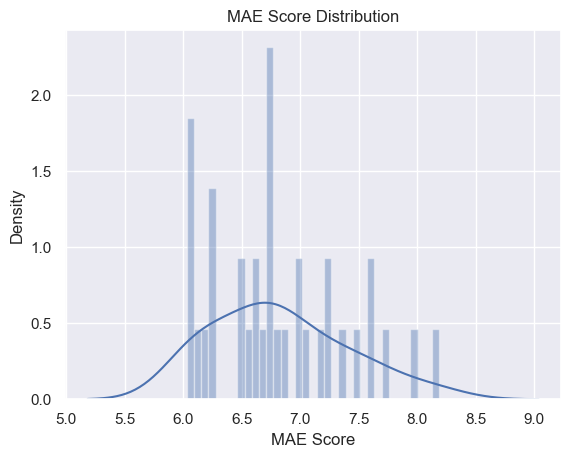

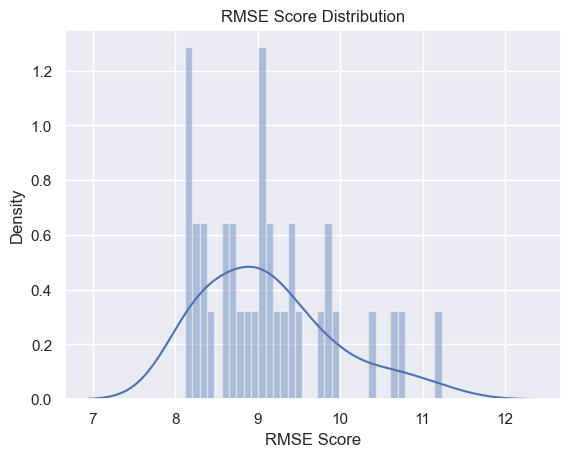

In [14]:
sns.set(style="darkgrid")
sns.distplot(mae_values_2, bins=35).set_title('MAE Score Distribution')
plt.xlabel("MAE Score")
plt.show()

sns.set(style="darkgrid")
sns.distplot(rmse_values_2, bins=35).set_title('RMSE Score Distribution')
plt.xlabel("RMSE Score")
plt.show()

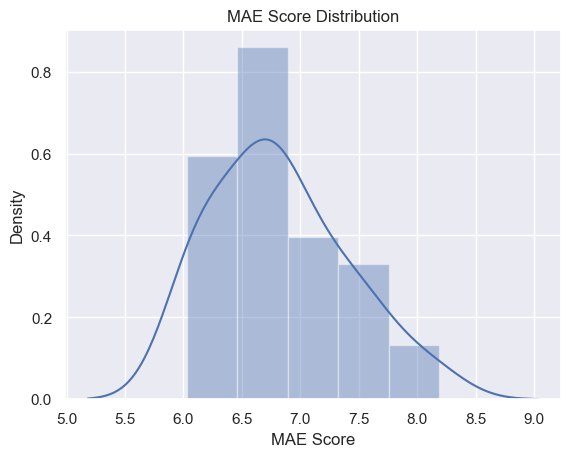

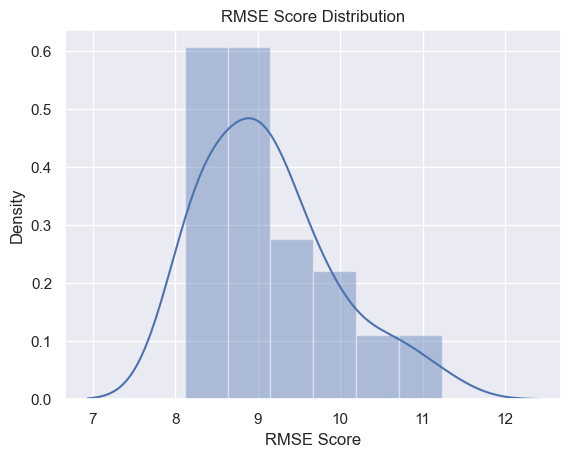

In [15]:
sns.set(style="darkgrid")
sns.distplot(mae_values_2).set_title('MAE Score Distribution')
plt.xlabel("MAE Score")
plt.show()

sns.set(style="darkgrid")
sns.distplot(rmse_values_2).set_title('RMSE Score Distribution')
plt.xlabel("RMSE Score")
plt.show()

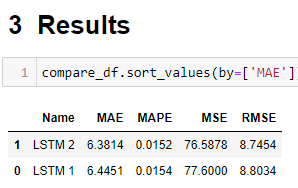

# Results

In [13]:
compare_df.sort_values(by=['MAE'])

,Name,MAE,MAPE,MSE,RMSE
0,LSTM 2,6.82,0.0163,83.773,9.1188


https://machinelearningmastery.com/estimate-number-experiment-repeats-stochastic-machine-learning-algorithms/